# Online Shopper Behavior Prediction

By: Marde Cano

**Initial Objective:** To be able to predict whether a certain session will result to a purchase from an online store.

**DATASET SOURCE**: The dataset is publicly available at the UC Irvine Machine Learning Repository. [here](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset).

**BRIEF DESCRIPTION**: The dataset consists of feature vectors belonging to 12,330 (online) sessions. The dataset was formed so that each session would belong to a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user profile, or period. 

Of the 12,330 sessions in the dataset, 84.5% (10,422) were negative class samples that did not end with shopping, and the rest (1908) were positive class samples ending with shopping.

The `'Revenue'` attribute will be my target values for this machine learning project. The project should be able to predict whether an online shopper (web user) will purchase a product from an online store, thus it is a *classification* problem.







In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer


# Models
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix

In [ ]:
# display a countplot with count labels 
def plot_data_count(df, col, hue, figsize=(10,6)):
    
    plt.figure(figsize=figsize)
    ax = sns.countplot(data=df, x=col, hue=hue)
    for rect in ax.patches:
        h = rect.get_height()
        w = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        ax.annotate(f"{h}", (x+w/2, h), ha='center', va='bottom', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.show()

# display inertia and silhouette scores
def plot_k_values(data, ks):
  """plot the silhouette score and inertia 
  of a KMeans model for various k values"""

  sils = []
  inertias = []

  for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(data)
    sils.append(silhouette_score(data, km.labels_))
    inertias.append(km.inertia_)
      
    # plot inertia and silhouette score
  fig, ax1 = plt.subplots(figsize=(9,7))
  ax1.set_xlabel('number of clusters')
  ax1.set_ylabel('Inertia', color = 'blue')
  ax1.plot(ks, inertias, color = 'blue',label='inertia',marker ='o')

  ax2 = ax1.twinx()
  
  ax2.set_ylabel('Silhouette Score', color = 'red')
  ax2.plot(ks, sils, color = 'red',label='silhouette score',marker='+')
  ax1.legend(loc=0)  
  ax2.legend(loc='upper left')
  plt.grid()
  plt.show()


# Use this function to see how your model improves over time
def plot_history(history, metric=None):
  """plot loss and passed metric.  metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(2,1, figsize = (5,10))
  axes[0].plot(history.history['loss'], label = "train")
  axes[0].plot(history.history['val_loss'], label='test')
  axes[0].set_title('Loss')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'train')
    axes[1].plot(history.history['val_' + metric], label = 'test')
    axes[1].set_title(metric)
    axes[1].legend()

  plt.show()

In [ ]:
# load dataset
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo/Datasets/online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
# get the datasets info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [ ]:
# get the number of rows and columns
df.shape

(12330, 18)

The dataset consists of 10 numerical and 8 categorical attributes. In total, there are **18** features (columns) and **12,330** records (rows) available to use for our model.

I am not expecting any major issues to encounter in the process of data cleaning. Since the dataset came from a online store, most of the information is system (website) generated. Consistency of data will not be a big issue, especially the data collected came from an automated system like an online store. Outliers will be managed as this kind of data can affect our analysis and model performance later.

In [ ]:
# get the statistical information of our numerical features
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


## Data Cleaning

In [ ]:
# check for missing values and duplicates
print(f'Missing values: \n{df.isna().sum()}\n')
print(f'Duplicates: {df.duplicated().sum()} records')

Missing values: 
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Duplicates: 125 records


In [ ]:
# drop all duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [ ]:
# check the distribution of sample data
df['Revenue'].value_counts(normalize=True)

False    0.843671
True     0.156329
Name: Revenue, dtype: float64

## EDA

#### Univariate EDA



Percent share for each category:
0.0    89.766489
0.6     2.867677
0.8     2.654650
0.4     1.990987
0.2     1.458419
1.0     1.261778
Name: SpecialDay, dtype: float64


Percent share for each category:
May     27.275707
Nov     24.432610
Mar     15.239656
Dec     13.977878
Oct      4.498156
Sep      3.670627
Aug      3.547726
Jul      3.539533
June     2.335109
Feb      1.482999
Name: Month, dtype: float64


Percent share for each category:
2    53.592790
1    20.884883
3    20.729209
4     3.916428
8     0.614502
6     0.155674
7     0.057354
5     0.049160
Name: OperatingSystems, dtype: float64


Percent share for each category:
2     64.588283
1     19.885293
4      5.989349
5      3.809914
6      1.425645
10     1.335518
8      1.106104
3      0.860303
13     0.458828
7      0.401475
12     0.081934
11     0.049160
9      0.008193
Name: Browser, dtype: float64


Percent share for each category:
1    38.623515
3    19.492011
4     9.594429
2     9.242114
6     6.562884
7     6.21

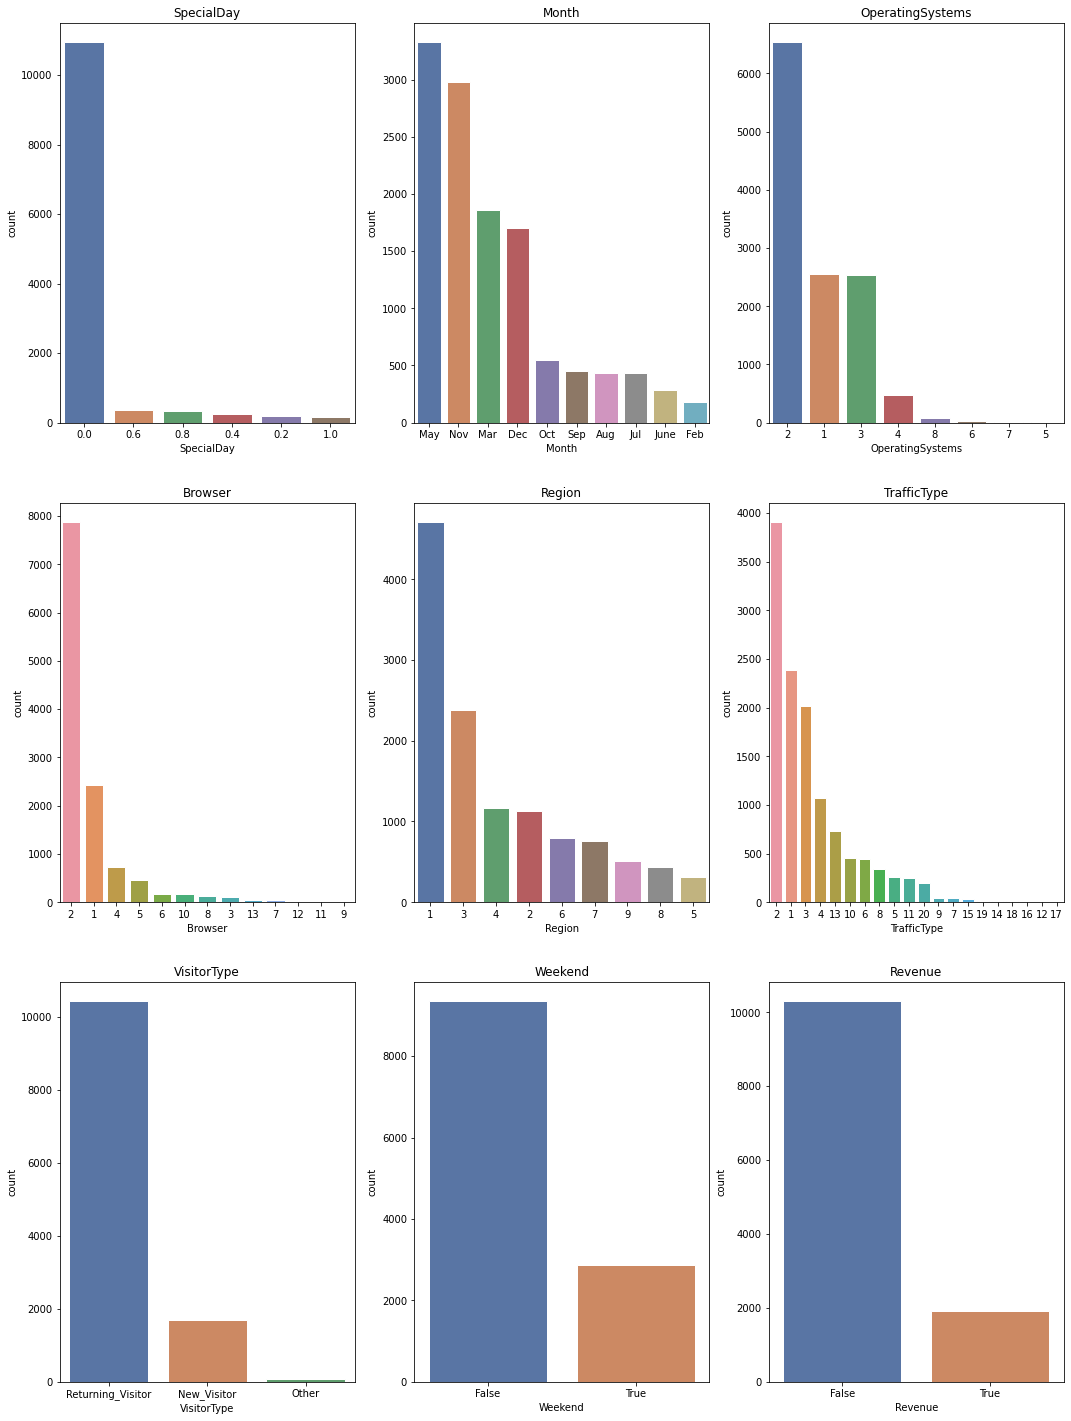

In [ ]:
# configure the subplots and  set figure size
fig, axes = plt.subplots(3, 3, figsize=(18, 25))
sns.set_theme(style="darkgrid")

# flatten the list
axes = axes.ravel()

# loop through some of the columns
for index,col in enumerate(df.columns[9:]):
  ax = sns.countplot(ax=axes[index], x=df[col], order=df[col].value_counts(ascending=False).index)
  axes[index].set_title(col)
  
  print("\n")
  print("Percent share for each category:")
  print(df[col].value_counts(normalize=True)*100)


 - The month of May tops the most number of web visitors followed by November and March, respectively.
 - There is a spike in numbers of visitors during special holidays.
 - Most web visitors uses Type 2 Operating system followed by Type 1 in second and Type 3 in third mostly used OS.
 - Type 2 browsers are widely used by the web visitors to access the online store.
 - Region 1 has the most number of users visit the website followed by Region 3 users.
 - There are more returning visitors of the website than the new visitors.
 - Most web users visit the website on weekdays.
 - Only 15.6% of the total web visitors ended up in buying from the online store.

#### Multi-variate EDA

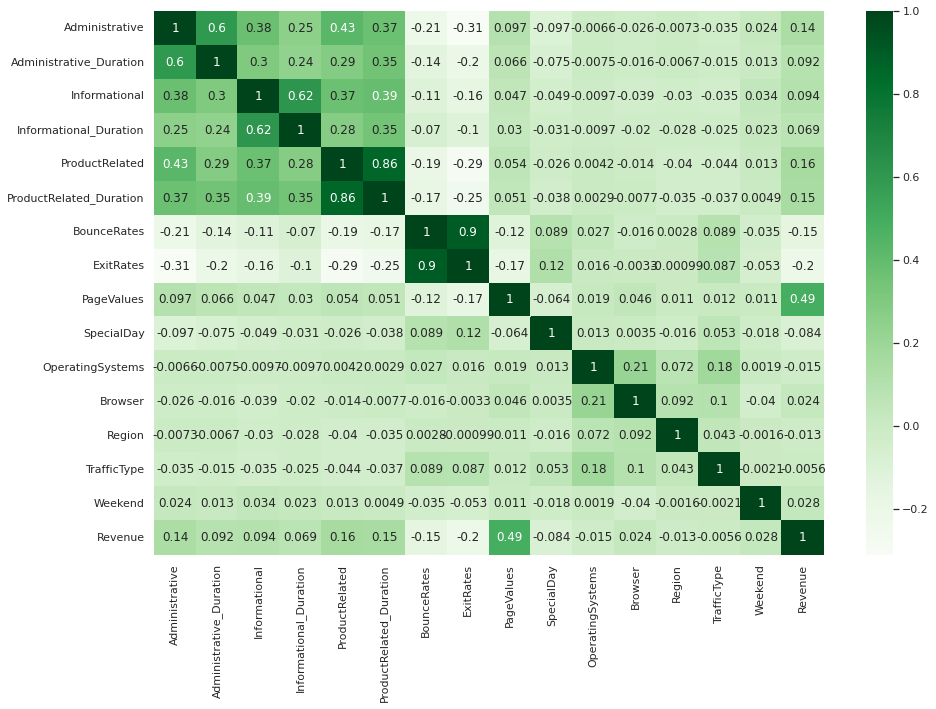

In [ ]:
# calculate correlation
corr = df.corr()

plt.figure(figsize=(15,10))
# display the heatmap
sns.heatmap(corr, annot=True, cmap='Greens')

It is very much obvious that the different types of pages visited by the visitor, namely, Administrative, Informational and Product Related, and the total time spent in each of these page categories have had high positive correlation to each other. 

However, for the other features, there are not much notable correlation except between Revenue and PageValues with 49% positive correlation.

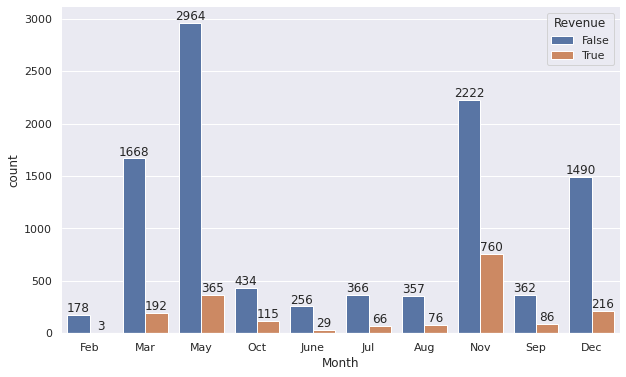

In [ ]:
# display relationship between Month and Revenue
plot_data_count(df,'Month','Revenue')

*Although May has the most number of website visitors, it is in **November** where most purchases were made through the online store, followed by May, then December.*

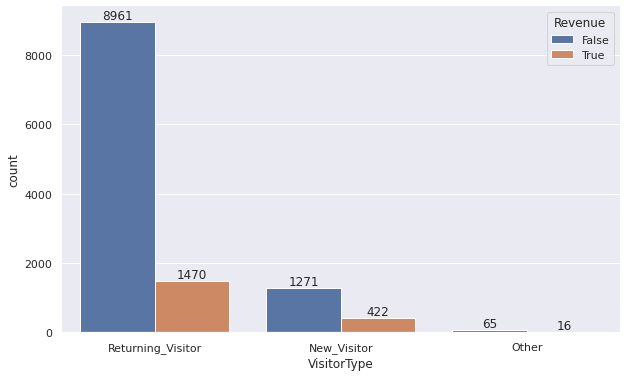

In [ ]:
# display relationship between VisitorType and Revenue
plot_data_count(df,'VisitorType','Revenue')

*Returning visitors provides more revenue to the company than new visitors.*

*In terms of conversion rates, new_visitors has higher percentage than of returning visitors.*

**RECOMMENDATION:** *Give out promotional discounts or vouchers, or other type of marketing startegies to new customers to make purchases. Example, a first purchase discount voucher.*

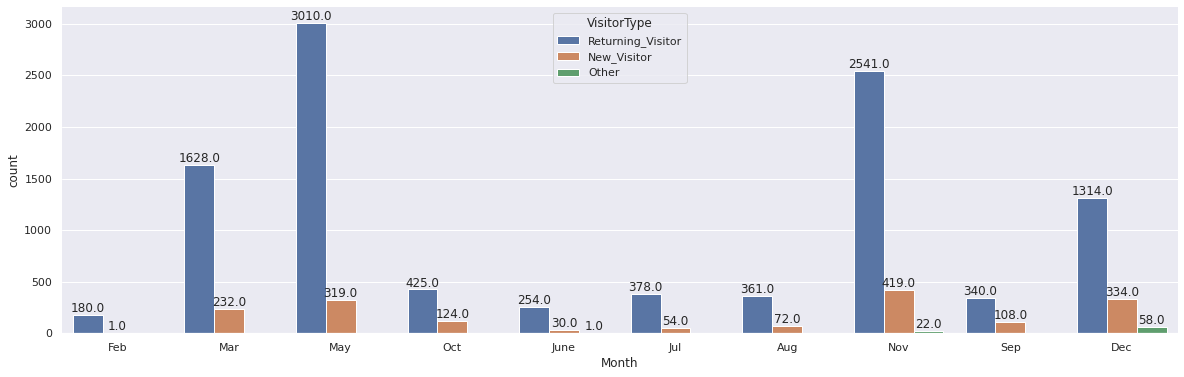

In [ ]:
plot_data_count(df, 'Month', 'VisitorType', figsize=(20,6))

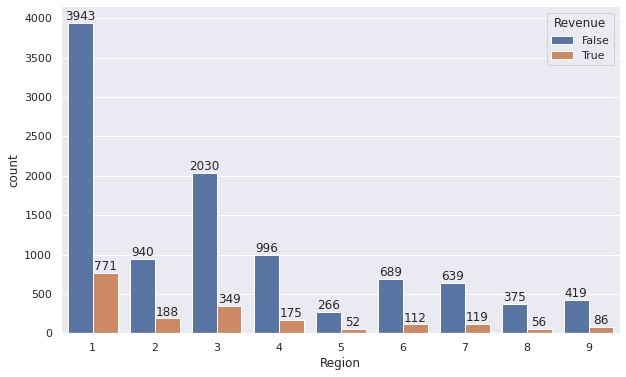

In [ ]:
# display relationship between Region and Revenue
plot_data_count(df,'Region','Revenue')

*The most number of website visitors and highest sales came from* **Region 1.**

**RECOMMENDATION:** *A dedicated warehouse could be built or rent our to cater the region. The aim is to have a smoother flow of stocks and improve delivery time in the region.*

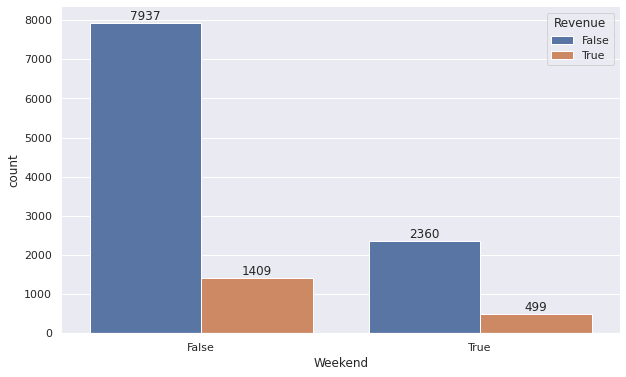

In [ ]:
plot_data_count(df,'Weekend','Revenue')

*It is in weekdays that has the most number of visitors and most purchased were made.*

**RECOMMENDATION:** *We can exploit this by running promotions during weekdays, rather than on weekends.*

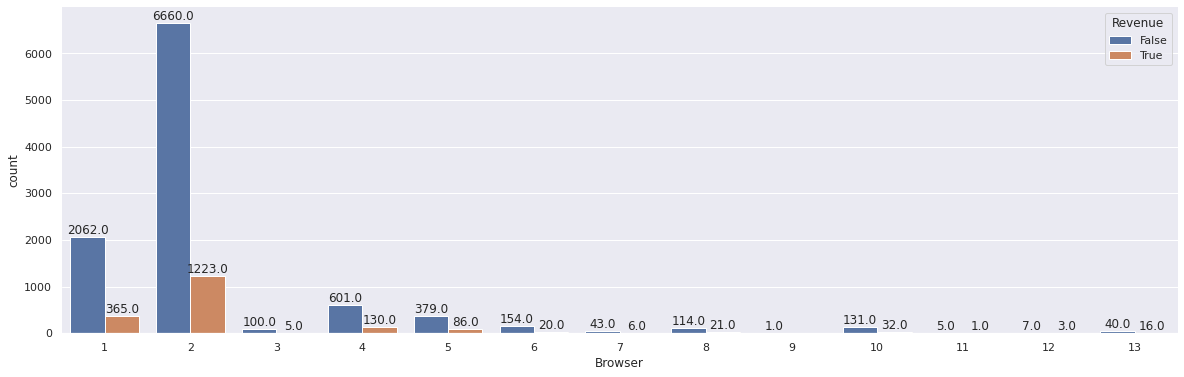

In [ ]:
plot_data_count(df,'Browser','Revenue', figsize=(20,6))

*Browser 2 was the most used platform by website visitors and was used to purchased thru online.* 

**RECOMMENDATION:** *Check with Web Development team the UI and UX advantages used for Browser 2 and, probably, apply the same interfaces to other browser platform.*

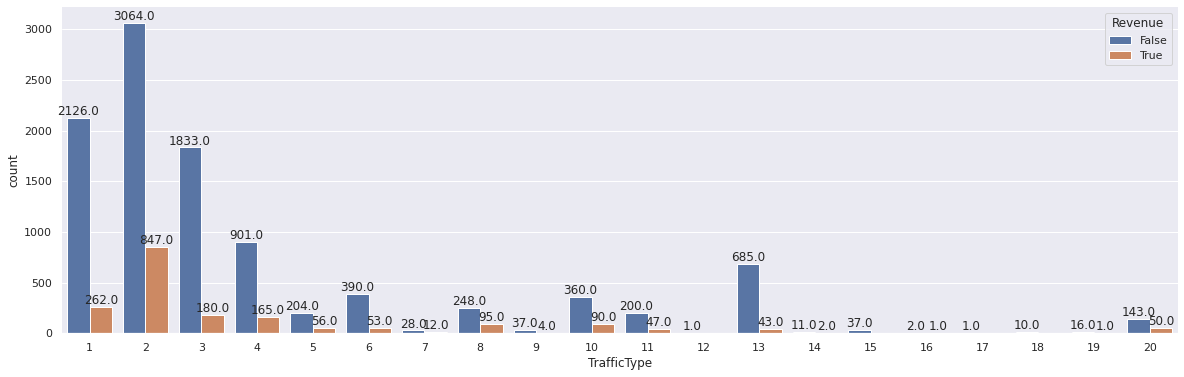

In [ ]:
plot_data_count(df,'TrafficType','Revenue', figsize=(20,6))

*Most revenue came from TrafficType #2. Followed by TrafficTypes #1 and #3.*

**RECOMMENDATION:** The marketing team could make plans on how to maximize the sources of the traffic.

### Validation Split

In [ ]:
# split the X features and y target
X = df.drop(columns=['Revenue','TrafficType','Weekend'], axis=1)
y = df['Revenue']

# split the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

#### Preprocess

In [ ]:
# instantiate StandardScaler, One-Hot Encoder
scaler = StandardScaler()
ohe = OneHotEncoder()

# select object and number datatype columns
cat_select = make_column_selector(dtype_include='object')
num_select = make_column_selector(dtype_include='number')

# pipeline
cat_pipe = make_pipeline(ohe)
num_pipe = make_pipeline(scaler)

# tuples
cat_tuple = (cat_pipe, cat_select)
num_tuple = (num_pipe, num_select)

# column transformer
preprocessor = make_column_transformer(cat_tuple, num_tuple)

#### Clustering

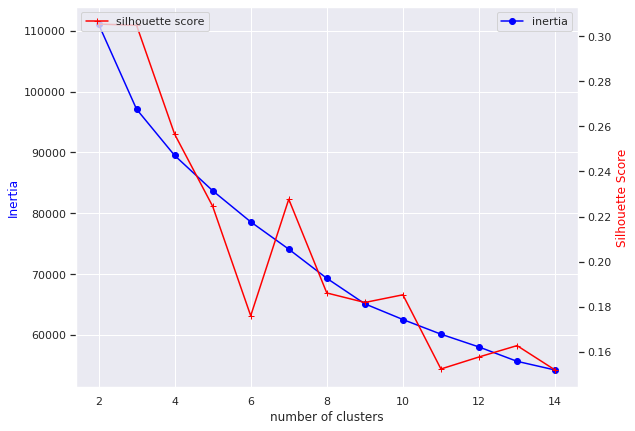

In [ ]:
# fit and transform preprocess to our train and test sets
X_train_processed= preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# find best k
ks = range(2,15)

plot_k_values(X_train_processed, ks)

*We have options to use 2 and 3 for the number of clusters. However, I decided to its good to use 3 clusters.*

In [ ]:
# instantiate KMeans
km = KMeans(n_clusters = 3)

# make a pipeline
km_pipe = make_pipeline(preprocessor, km)

# fit the model
km_pipe.fit(X_train)

# create another column for cluster
X_train['cluster'] = km_pipe.predict(X_train)
X_test['cluster'] = km_pipe.predict(X_test)

## Deep Learning

In [ ]:
# instantiate a deep learning model
model1 = Sequential()

model1.add(Dense(10, input_dim = X_train_processed.shape[1],
                activation = 'relu'))
model1.add(Dropout(.2))

#model1.add(Dense(10, activation = 'relu'))
#model1.add(Dropout(.2)) # add droupout to regularize

model1.add(Dense(1, activation = 'sigmoid'))
early_stopping = EarlyStopping(patience = 5)

model1.compile(loss='bce', optimizer='adam', metrics=['acc'])

history = model1.fit(X_train_processed, y_train,
                    validation_data=(X_test_processed, y_test),
                    epochs=100,
                    callbacks = [early_stopping])

Epoch 1/100
287/287 [==============================] - 2s 3ms/step - loss: 0.5168 - acc: 0.7655 - val_loss: 0.3562 - val_acc: 0.8594
Epoch 2/100
287/287 [==============================] - 1s 2ms/step - loss: 0.3447 - acc: 0.8647 - val_loss: 0.2992 - val_acc: 0.8761
Epoch 3/100
287/287 [==============================] - 1s 2ms/step - loss: 0.3123 - acc: 0.8758 - val_loss: 0.2820 - val_acc: 0.8827
Epoch 4/100
287/287 [==============================] - 1s 2ms/step - loss: 0.2994 - acc: 0.8814 - val_loss: 0.2734 - val_acc: 0.8863
Epoch 5/100
287/287 [==============================] - 1s 2ms/step - loss: 0.2898 - acc: 0.8873 - val_loss: 0.2673 - val_acc: 0.8879
Epoch 6/100
287/287 [==============================] - 1s 2ms/step - loss: 0.2834 - acc: 0.8874 - val_loss: 0.2628 - val_acc: 0.8902
Epoch 7/100
287/287 [==============================] - 1s 2ms/step - loss: 0.2776 - acc: 0.8893 - val_loss: 0.2585 - val_acc: 0.8899
Epoch 8/100
287/287 [==============================] - 1s 2ms/step - 

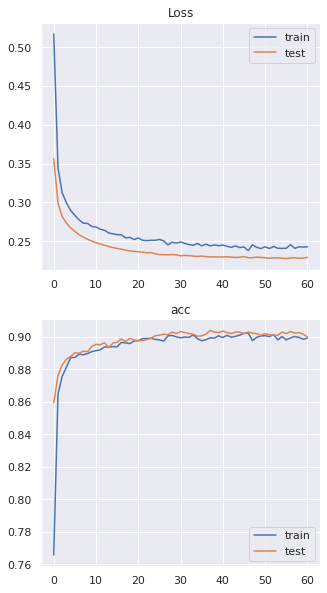

In [ ]:
plot_history(history, metric='acc')

In [ ]:
# predict using the model
preds = np.rint(model1.predict(X_test_processed))

# display classification report and confusion matrix
print(classification_report(y_test, preds))

confusion_matrix(y_test, preds, normalize='true')

              precision    recall  f1-score   support

       False       0.92      0.96      0.94      2575
        True       0.73      0.57      0.64       477

    accuracy                           0.90      3052
   macro avg       0.83      0.77      0.79      3052
weighted avg       0.89      0.90      0.89      3052



array([[0.96116505, 0.03883495],
       [0.42976939, 0.57023061]])

### Random Forest

In [ ]:
# instantiate Random Forest
rf = RandomForestClassifier()

# make a pipeline
rf_pipe = make_pipeline(preprocessor, rf)

# train the model
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3c0a337790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3c0a3377d0>)])),
                ('randomforestclassifier', RandomForestClassifier())])

In [ ]:
preds = rf_pipe.predict(X_test)

print(classification_report(y_test, preds))

confusion_matrix(y_test, preds, normalize='true')

              precision    recall  f1-score   support

       False       0.92      0.96      0.94      2575
        True       0.73      0.58      0.64       477

    accuracy                           0.90      3052
   macro avg       0.83      0.77      0.79      3052
weighted avg       0.89      0.90      0.89      3052



array([[0.95961165, 0.04038835],
       [0.42348008, 0.57651992]])

### XGBoost

In [ ]:
# instantiate XG Boost
xgb = XGBClassifier(gamma=0.3, learning_rate=0.05, max_depth=5, 
                    min_child_weight=3)

# make a pipeline
xgb_pipe = make_pipeline(preprocessor, xgb)

# train the model
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3c0a337790>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3c0a3377d0>)])),
                ('xgbclassifier',
                 XGBClassifier(gamma=0.3, learning_rate=0.05, max_depth=5,
                               min_child_weight=3))])

In [ ]:
preds = xgb_pipe.predict(X_test)

print(classification_report(y_test, preds))

confusion_matrix(y_test, preds, normalize='true')

              precision    recall  f1-score   support

       False       0.93      0.95      0.94      2575
        True       0.72      0.63      0.67       477

    accuracy                           0.90      3052
   macro avg       0.83      0.79      0.81      3052
weighted avg       0.90      0.90      0.90      3052



array([[0.95456311, 0.04543689],
       [0.37106918, 0.62893082]])

For the final model, I opt to use XGBoost ML as it detects well compared to RandomForestClassifier and Deep Learning model.